# Notebook for Sleep Detection

Algorithm based on: <br>
`V. van Hees, et al., “Estimating sleep parameters using an accelerometer without sleep diary,” Scientific Reports, vol. 8, 2018.`

In [1]:
import time
import os
import sys
import getpass
from pathlib import Path

import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt

In [2]:
user = getpass.getuser()
data_path = '/Users/{}/GitHub/fydp-data-science/data/ondri_data/'.format(user)

## Methods for sleep detection

#### Sleep detection code
- steps follow those outlined in Van Hees 2018

In [24]:
def sleep_detection(acc_data, sampling_rate):
    
    data = acc_data.copy()
    
    # step 1: calculating rolling 5 second median of signals      
    data['x_median'] = data.x.rolling(5*sampling_rate).median()
    data['y_median'] = data.y.rolling(5*sampling_rate).median()
    data['z_median'] = data.z.rolling(5*sampling_rate).median()
    
    print ('completed step 1')

    # step 2: calculating arm angle
    data['angle'] = np.arctan(data.z_median / np.sqrt(np.square(data.x_median) + np.square(data.y_median))) * 180 / np.pi
   
    print ('completed step 2')

    # step 3: calculating 5 second averages   
    data['avg_angle'] = data.angle.rolling(5*sampling_rate).mean()
    
    print ('completed step 3')

    # step 4: calculating absolute differences between successive values
    data['angle_diff'] = data.avg_angle.diff()
    
    print ('completed step 4')

    # step 5: rolling median using 5 min window
    data['median_diff'] = data.angle_diff.rolling(5*60*sampling_rate).median()
    
    print ('completed step 5')

    # step 6: detecting 10th percentile of values and multipling by constant 15
    critical_threshold = 15*data.median_diff.quantile(0.1)
    
    print ('completed step 6')

    # step 7 & 8: keeping blocks > 30 min and < 60min
    start_index = 0
    thirty_threshold = 30*60*sampling_rate
    period_count = 0
    sleep_periods = []
    wake_periods = []
    
    for idx, row in data.iterrows():
        # skip the zero case to avoid errors
        if idx != 0:
            # if median successive differences depicts low movement
            if row.median_diff < critical_threshold:
                period_count = period_count+1

            else: 
                end_index = idx-1

                # if time below critical threshold is greater than 30min, label as sleep
                if period_count >= thirty_threshold:
                    sleep_periods.append([start_index,end_index])
                else:
                    wake_periods.append([start_index,end_index])
                    
                # update start index of the next period and the period count
                start_index = idx
                period_count = 0
                
    print ('completed steps 7 & 8')
                
    # label the data based on the sleep and wake periods
    sleep_wake_periods = data.copy()
    
    for period in sleep_periods:
        for j in range(period[0],period[1]):
            sleep_wake_periods.loc[j,'label'] = 'sleep'
        
    for period in wake_periods:
        for j in range(period[0],period[1]):
            sleep_wake_periods.loc[j,'label'] = 'wake'
            
    print ('labelled sleep & wake periods')

    # note that the longest block of the day is labelled as the SPT-window   
    return sleep_wake_periods

#### Function for visualizing sleep and wake periods

In [20]:
def visualize_sleep_wake(data):
    # set up figure
    plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.title('Visualization of sleep and wake periods')
    plt.xlabel('time')
    plt.ylabel('period')
   
    plt.plot(data[data.label == 'sleep'].time, data[data.label == 'sleep'].label, color='#56C1FF', alpha=0.8, label='sleep period')
    plt.plot(data[data.label == 'wake'].time, data[data.label == 'wake'].label, color='#88FA4E', alpha=0.8, label='wake period')
    
    plt.legend()

## Pulling in data

In [3]:
acc_data = pd.read_csv(data_path + 'acc_data.csv', index_col=0).reset_index().rename(columns={'index':'time'})
acc_data.head()

/Users/sunnywillert/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,time,x,y,z
0,0,-0.050722,-0.041538,-1.015312
1,1,-0.062537,-0.045464,-1.007386
2,2,-0.062537,-0.041538,-1.007386
3,3,-0.046783,-0.049391,-0.999459
4,4,-0.046783,-0.053318,-1.007386


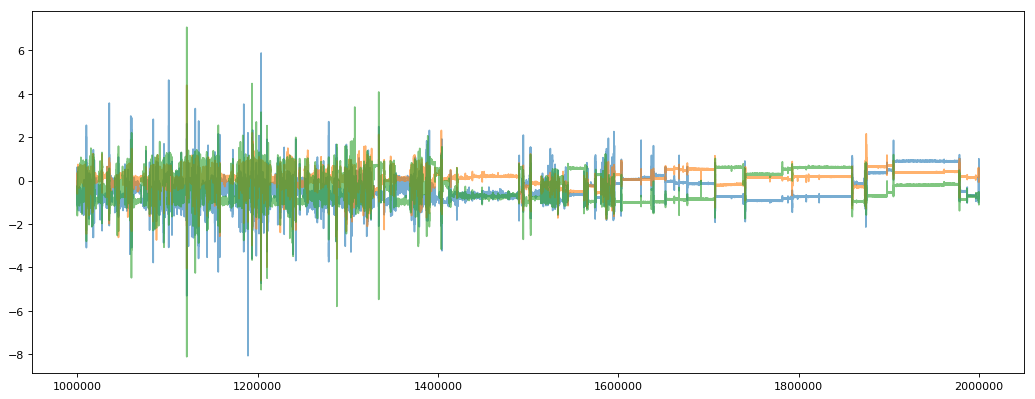

In [4]:
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(acc_data.x[1000000:2000000], alpha=0.6)
plt.plot(acc_data.y[1000000:2000000], alpha=0.6)
plt.plot(acc_data.z[1000000:2000000], alpha=0.6)

In [5]:
data = acc_data[1300000:1500000]

In [6]:
sampling_rate = 100

## Running code

In [ ]:
sleep_wake_periods = sleep_detection(data, sampling_rate)

In [ ]:
visualize_sleep_wake(sleep_wake_periods)